In [47]:
from cleaning import database_cleaner

from pprint import pprint
import string
import re

# Gensim
import gensim
from gensim.models import CoherenceModel
from gensim import models, corpora
from gensim import similarities

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK
from nltk.corpus import stopwords
from nltk import word_tokenize

# spacy for lemmatization
import spacy

In [2]:
def get_data(filename):
    """Load raw data from a file and return vectorizer and feature_matrix.
    Parameters
    ----------
    filename: The path to a json file containing the university database.
    Returns
    -------
    corpus: A numpy array containing abstracts.
    """
    df_cleaned = database_cleaner(filename)

    # For nlp, only retaining faculty_name, research_areas, paper_titles, abstracts
    df_filtered = df_cleaned[['faculty_name', 'research_areas', 'paper_titles', 'abstracts']]
    missing = df_filtered['paper_titles'] == ''
    num_missing = sum(missing)
    print(f'{num_missing} faculties have missing papers in {filename}')
    print('Running nlp-pipeline on faculties with non-missing papers...')

    df_nlp = df_filtered[~missing]

    # Choosing abstracts and paper_titles to predict topics for a professor
    data = (df_nlp['paper_titles'] + df_nlp['abstracts']).values

    return data

data = get_data('../data/pge_database.json')

0 faculties have missing papers in ../data/pge_database.json
Running nlp-pipeline on faculties with non-missing papers...


In [3]:
data.shape

(75,)

In [4]:
# NLTK Stop words
stopwords_ = stopwords.words('english')

def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in stopwords_ and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return cleaned_text
 
# For gensim we need to tokenize the data and filter out stopwords
tokens_filtered = []
for text in data:
    tokens_filtered.append(clean_text(text))

# def filter_tokens(sent):
#     return([w for w in sent if not w in stopwords_ and not w in punctuation_ and re.match('[a-zA-Z-][a-zA-Z-]{2,}]', w)])

# tokens = [word_tokenize(doc) for doc in corpus]
# tokens_lower = [[word.lower() for word in sent] for sent in tokens]
# tokens_filtered = list(map(filter_tokens, tokens_lower))

<input>:6: DeprecationWarning: invalid escape sequence \-
<input>:6: DeprecationWarning: invalid escape sequence \-
<input>:6: DeprecationWarning: invalid escape sequence \-
<ipython-input-4-f0dc57127820>:6: DeprecationWarning: invalid escape sequence \-
  cleaned_text = [t for t in tokenized_text if t not in stopwords_ and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]


In [5]:
# Build the bigram and trigram models
import warnings
warnings.filterwarnings("ignore",category=UserWarning)

bigram = gensim.models.Phrases(tokens_filtered, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokens_filtered], threshold=100) 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [6]:
# Form Bigrams
tokens_bigrams = make_bigrams(tokens_filtered)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(tokens_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [7]:
n_topics = 9

# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(tokens_filtered)

In [8]:
# Transform the collection of texts to a numerical form [(word_id, count), ...]
corpus = [dictionary.doc2bow(text) for text in tokens_filtered]

In [9]:
tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary) # tfidf gives better coherence score

lda_model = gensim.models.ldamodel.LdaModel(tfidf_model[corpus], id2word=dictionary, num_topics=n_topics)

# Build the LDA model
# lda_model = models.LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)
 
# Build the LSI model
lsi_model = models.LsiModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)

In [10]:
print("LDA Model:")
 
for idx in range(n_topics):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))
 
print("=" * 20)
 
print("LSI Model:")
 
for idx in range(n_topics):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lsi_model.print_topic(idx, 10))
 
print("=" * 20)

LDA Model:
Topic #0: 0.000*"acid" + 0.000*"restimulation" + 0.000*"fracture" + 0.000*"matrix-vug" + 0.000*"bit" + 0.000*"vuggy" + 0.000*"carbonate" + 0.000*"borehole" + 0.000*"vugs" + 0.000*"stimulation"
Topic #1: 0.000*"archie" + 0.000*"herrick" + 0.000*"kennedy" + 0.000*"flaws" + 0.000*"resistivity" + 0.000*"kerogen" + 0.000*"nmr" + 0.000*"sub-core" + 0.000*"contingency" + 0.000*"capillary"
Topic #2: 0.000*"battery" + 0.000*"combustion" + 0.000*"steam" + 0.000*"crm" + 0.000*"isc" + 0.000*"tpwl" + 0.000*"vrr" + 0.000*"solar" + 0.000*"aging" + 0.000*"foam"
Topic #3: 0.000*"foam" + 0.000*"surfactants" + 0.000*"combustion" + 0.000*"reserves" + 0.000*"surfactant" + 0.000*"sec" + 0.000*"lrs" + 0.000*"gel" + 0.000*"pvs" + 0.000*"bodies"
Topic #4: 0.000*"basins" + 0.000*"seismic" + 0.000*"peridynamic" + 0.000*"cement" + 0.000*"acid" + 0.000*"frontier" + 0.000*"casing" + 0.000*"drillstring" + 0.000*"simpleware" + 0.000*"bit"
Topic #5: 0.000*"geosteering" + 0.000*"foam" + 0.000*"pga" + 0.000*"

In [11]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens_filtered, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.0404446718

Coherence Score:  0.4351486909


In [12]:
# LDA Mallet (slower)
mallet_path = '~/Documents/GitHub/capstone/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=n_topics, id2word=dictionary, prefix='~/Documents/Github/capstone/')

In [13]:
# Show Topics
#pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=tokens_filtered, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.492524031243


# Choosing number of topics

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokens_filtered, start=5, limit=21, step=2)

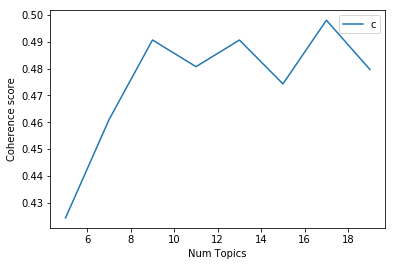

In [16]:
# Show graph
limit=21; start=5; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
# Print the coherence scores (9 seems to be optimal here)
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.4244
Num Topics = 7  has Coherence Value of 0.461
Num Topics = 9  has Coherence Value of 0.4906
Num Topics = 11  has Coherence Value of 0.4807
Num Topics = 13  has Coherence Value of 0.4906
Num Topics = 15  has Coherence Value of 0.4743
Num Topics = 17  has Coherence Value of 0.498
Num Topics = 19  has Coherence Value of 0.4797


In [19]:
# Visualize the topics with simple lda model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      59.376312        1       1  0.003054  0.000183
8      14.199469        1       2 -0.001261 -0.000404
3      13.010584        1       3  0.000099  0.001400
5       6.554146        1       4  0.000343 -0.002010
0       2.394135        1       5 -0.000171  0.000719
2       1.925245        1       6 -0.000849  0.000428
4       1.498912        1       7 -0.000172 -0.000770
7       0.749904        1       8 -0.000663 -0.000026
1       0.291294        1       9 -0.000379  0.000479, topic_info=      Category        Freq               Term       Total  loglift  logprob
term                                                                       
24     Default   94.000000               acid   94.000000  30.0000  30.0000
989    Default   92.000000           fracture   92.000000  29.0000  29.0000
5457   Default   76.000000               foam   76.000000  28.0000  28.0000
434    Default   59.000000       conductivity   59.000000  27.0000  27.0000
5530   Default  129.000000            hydrate  129.000000  26.0000  26.0000
275    Default   58.000000          capillary   58.000000  25.0000  25.0000
1719   Default   70.000000       permeability   70.000000  24.0000  24.0000
304    Default   63.000000             cement   63.000000  23.0000  23.0000
5695   Default   89.000000      nanoparticles   89.000000  22.0000  22.0000
10978  Default   54.000000        peridynamic   54.000000  21.0000  21.0000
3800   Default   40.000000         combustion   40.000000  20.0000  20.0000
5589   Default   51.000000            kerogen   51.000000  19.0000  19.0000
2287   Default   65.000000             stress   65.000000  18.0000  18.0000
5150   Default   95.000000         surfactant   95.000000  17.0000  17.0000
999    Default   71.000000          fractures   71.000000  16.0000  16.0000
1615   Default   65.000000                oil   65.000000  15.0000  15.0000
1156   Default   67.000000         imbibition   67.000000  14.0000  14.0000
1029   Default   59.000000                gas   59.000000  13.0000  13.0000
1227   Default   55.000000          injection   55.000000  12.0000  12.0000
9070   Default   36.000000                crm   36.000000  11.0000  11.0000
1759   Default   87.000000            polymer   87.000000  10.0000  10.0000
1864   Default   47.000000           proppant   47.000000   9.0000   9.0000
2069   Default   62.000000         saturation   62.000000   8.0000   8.0000
8608   Default   40.000000             basins   40.000000   7.0000   7.0000
2002   Default   61.000000          reservoir   61.000000   6.0000   6.0000
2136   Default   62.000000              shale   62.000000   5.0000   5.0000
3584   Default   37.000000              steam   37.000000   4.0000   4.0000
1642   Default   55.000000       organic-rich   55.000000   3.0000   3.0000
4860   Default   39.000000            seismic   39.000000   2.0000   2.0000
6147   Default   40.000000        phase-field   40.000000   1.0000   1.0000
...        ...         ...                ...         ...      ...      ...
15611   Topic9    0.142607            ganglia   21.661728   0.8154  -9.1969
19808   Topic9    0.130199                pet   20.939573   0.7583  -9.2879
16738   Topic9    0.128188          confusion   21.334751   0.7240  -9.3035
3195    Topic9    0.164501            leakage   28.569521   0.6814  -9.0541
16868   Topic9    0.120960         colleagues   21.353188   0.6651  -9.3615
5316    Topic9    0.119757       constriction   21.373373   0.6542  -9.3715
19793   Topic9    0.116979           mm-scale   20.924187   0.6519  -9.3950
19842   Topic9    0.116531      subcore-scale   20.926664   0.6480  -9.3988
19854   Topic9    0.116155      wetting-phase   20.928793   0.6446  -9.4021
19845   Topic9    0.116097  synchrotron-based   20.929092   0.6441  -9.4026
19709   Topic9    0.116048               bevs   20.929350   0.6437  -9.4030
20880   Topic9    0

# Visualizing best lda_mallet model
* Code taken from: https://github.com/jerielizabeth/Gospel-of-Health-Notebooks/blob/master/blogPosts/pyLDAvis_and_Mallet.ipynb

In [21]:
import gzip
import os
import pandas as pd

dataDir = "/Users/Neha/Documents/GitHub/capstone"

def extract_params(statefile):
    """Extract the alpha and beta values from the statefile.

    Args:
        statefile (str): Path to statefile produced by MALLET.
    Returns:
        tuple: alpha (list), beta    
    """
    with gzip.open(statefile, 'r') as state:
        params = [x.decode('utf8').strip() for x in state.readlines()[1:3]]
    return (list(params[0].split(":")[1].split(" ")), float(params[1].split(":")[1]))


def state_to_df(statefile):
    """Transform state file into pandas dataframe.
    The MALLET statefile is tab-separated, and the first two rows contain the alpha and beta hypterparamters.
    
    Args:
        statefile (str): Path to statefile produced by MALLET.
    Returns:
        datframe: topic assignment for each token in each document of the model
    """
    return pd.read_csv(statefile,
                       compression='gzip',
                       sep=' ',
                       skiprows=[1,2]
                       )


In [22]:
params = extract_params(os.path.join(dataDir, 'state.mallet.gz'))

In [23]:
alpha = [float(x) for x in params[0][1:]]
beta = params[1]
print("{}, {}".format(alpha, beta))

[5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555], 0.01


In [24]:
df = state_to_df(os.path.join(dataDir, 'state.mallet.gz'))

In [25]:
df['type'] = df.type.astype(str)
df[:10]

,#doc,source,pos,typeindex,type,topic
0,0,NaN,0,0,-based,7
1,0,NaN,1,1,-scan,7
2,0,NaN,2,2,ability,7
3,0,NaN,3,2,ability,5
4,0,NaN,4,2,ability,7
5,0,NaN,5,3,absence,3
6,0,NaN,6,4,abstract,7
7,0,NaN,7,4,abstract,7
8,0,NaN,8,4,abstract,7
9,0,NaN,9,4,abstract,7


In [26]:
# Get document lengths from statefile
docs = df.groupby('#doc')['type'].count().reset_index(name ='doc_length')

docs[:10]

,#doc,doc_length
0,0,14767
1,1,6476
2,2,2975
3,3,9746
4,4,1732
5,5,10177
6,6,858
7,7,10449
8,8,7576
9,9,2841


In [27]:
# Get vocab and term frequencies from statefile
vocab = df['type'].value_counts().reset_index()
vocab.columns = ['type', 'term_freq']
vocab = vocab.sort_values(by='type', ascending=True)

vocab[:10]

,type,term_freq
14150,-acetamide,1
9862,-acetate-hpam,2
4350,-based,11
20447,-benzoic,1
19420,-both,1
12945,-cost-effective,1
13803,-cpmg,1
17925,-density,1
10921,-derived,2
10808,-ethylenediaminetriacetic,2


In [28]:
#  Topic-term matrix from state file
# https://ldavis.cpsievert.me/reviews/reviews.html

import sklearn.preprocessing

def pivot_and_smooth(df, smooth_value, rows_variable, cols_variable, values_variable):
    """
    Turns the pandas dataframe into a data matrix.
    Args:
        df (dataframe): aggregated dataframe 
        smooth_value (float): value to add to the matrix to account for the priors
        rows_variable (str): name of dataframe column to use as the rows in the matrix
        cols_variable (str): name of dataframe column to use as the columns in the matrix
        values_variable(str): name of the dataframe column to use as the values in the matrix
    Returns:
        dataframe: pandas matrix that has been normalized on the rows.
    """
    matrix = df.pivot(index=rows_variable, columns=cols_variable, values=values_variable).fillna(value=0)
    matrix = matrix.values + smooth_value
    
    normed = sklearn.preprocessing.normalize(matrix, norm='l1', axis=1)
    
    return pd.DataFrame(normed)

In [29]:
phi_df = df.groupby(['topic', 'type'])['type'].count().reset_index(name ='token_count')
phi_df = phi_df.sort_values(by='type', ascending=True)

phi_df[:10]

,topic,type,token_count
0,0,-acetamide,1
1,0,-acetate-hpam,1
4299,1,-acetate-hpam,1
11285,3,-based,6
25290,7,-based,5
2,0,-benzoic,1
14343,4,-both,1
4300,1,-cost-effective,1
14344,4,-cpmg,1
17444,5,-density,1


In [30]:
phi = pivot_and_smooth(phi_df, beta, 'topic', 'type', 'token_count')

In [31]:
theta_df = df.groupby(['#doc', 'topic'])['topic'].count().reset_index(name ='topic_count')

theta_df[:10]

,#doc,topic,topic_count
0,0,0,193
1,0,1,321
2,0,2,48
3,0,3,344
4,0,4,184
5,0,5,419
6,0,6,1166
7,0,7,12002
8,0,8,90
9,1,0,3459


In [32]:
theta = pivot_and_smooth(theta_df, alpha , '#doc', 'topic', 'topic_count')

In [33]:
import pyLDAvis

data = {'topic_term_dists': phi, 
        'doc_topic_dists': theta,
        'doc_lengths': list(docs['doc_length']),
        'vocab': list(vocab['type']),
        'term_frequency': list(vocab['term_freq'])
       }

In [34]:
vis_data = pyLDAvis.prepare(**data)

In [35]:
vis_data

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      16.317058        1       1 -0.037771  0.024145
5      15.327788        1       2 -0.181904  0.101132
8      12.357484        1       3  0.040147 -0.022706
1      11.287493        1       4 -0.181450 -0.087697
3       9.503313        1       5  0.236680 -0.065162
0       9.466533        1       6 -0.130053 -0.068612
7       9.400222        1       7  0.025621  0.070419
4       8.234138        1       8  0.122185  0.245334
2       8.105972        1       9  0.106546 -0.196853, topic_info=      Category         Freq            Term        Total  loglift  logprob
term                                                                      
7006   Default  3609.000000        fracture  3609.000000  30.0000  30.0000
12699  Default  3863.000000             oil  3863.000000  29.0000  29.0000
171    Default  1113.000000            acid  1113.000000  28.0000  28.0000
7265   Default  3634.000000             gas  3634.000000  27.0000  27.0000
5149   Default  1070.000000        drilling  1070.000000  26.0000  26.0000
7071   Default  1518.000000       fractures  1518.000000  25.0000  25.0000
3289   Default   800.000000    conductivity   800.000000  24.0000  24.0000
8351   Default  1059.000000       hydraulic  1059.000000  23.0000  23.0000
15344  Default  1699.000000        recovery  1699.000000  22.0000  22.0000
19473  Default   918.000000  unconventional   918.000000  21.0000  21.0000
14585  Default  2719.000000      production  2719.000000  20.0000  20.0000
18501  Default  1178.000000     temperature  1178.000000  19.0000  19.0000
14030  Default   955.000000            pore   955.000000  18.0000  18.0000
6682   Default  3047.000000            flow  3047.000000  17.0000  17.0000
18193  Default   708.000000      surfactant   708.000000  16.0000  16.0000
16684  Default  2001.000000           shale  2001.000000  15.0000  15.0000
13561  Default  2032.000000    permeability  2032.000000  14.0000  14.0000
6812   Default   706.000000            foam   706.000000  13.0000  13.0000
13663  Default   954.000000           phase   954.000000  12.0000  12.0000
10841  Default   762.000000    measurements   762.000000  11.0000  11.0000
13984  Default   607.000000         polymer   607.000000  10.0000  10.0000
16015  Default  1329.000000            rock  1329.000000   9.0000   9.0000
20238  Default  1732.000000           water  1732.000000   8.0000   8.0000
15688  Default  3418.000000       reservoir  3418.000000   7.0000   7.0000
20478  Default   838.000000        wellbore   838.000000   6.0000   6.0000
7081   Default   909.000000      fracturing   909.000000   5.0000   5.0000
8985   Default  1507.000000       injection  1507.000000   4.0000   4.0000
15685  Default   435.000000        reserves   435.000000   3.0000   3.0000
17650  Default   431.000000           steam   431.000000   2.0000   2.0000
4076   Default  2268.000000            data  2268.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
13165   Topic9    46.874592          oxygen    50.932241   2.4295  -6.6431
7342    Topic9    58.840028           gases    68.866380   2.3552  -6.4157
5773    Topic9    80.776659             eos   105.798234   2.2427  -6.0989
13678   Topic9   137.612476          phases   226.389054   2.0148  -5.5661
7926    Topic9   162.540466            heat   290.122157   1.9332  -5.3996
13663   Topic9   364.955745           phase   954.970373   1.5507  -4.5908
12699   Topic9   916.362884             oil  3863.550204   1.0736  -3.6701
5651    Topic9   277.209220          energy   766.693376   1.4953  -4.8658
7674    Topic9   140.603835         gravity   273.309493   1.8479  -5.5446
18659   Topic9   201.428130         thermal   506.297299   1.5909  -5.1851
1520    Topic9   313.105526        behavior  1053.322083   1.2994  -4.7440
18501   Topic9   296.154492     temperature  1178.399759   1.13

# Dominant Topic for each professor

In [91]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    return(sent_topics_df)

In [93]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,0,7.0,0.8142,"fracture, acid, conductivity, temperature, mod..."
1,1,0.0,0.5406,"drilling, pressure, wellbore, data, cement, op..."
2,2,5.0,0.3706,"model, reservoir, approach, flow, simulation, ..."
3,3,5.0,0.7188,"model, reservoir, approach, flow, simulation, ..."
4,4,7.0,0.4135,"fracture, acid, conductivity, temperature, mod..."
5,5,2.0,0.2909,"oil, steam, phase, combustion, behavior, tempe..."
6,6,0.0,0.3128,"drilling, pressure, wellbore, data, cement, op..."
7,7,2.0,0.6952,"oil, steam, phase, combustion, behavior, tempe..."
8,8,4.0,0.6085,"pore, rock, measurements, properties, permeabi..."
9,9,5.0,0.6116,"model, reservoir, approach, flow, simulation, ..."


In [98]:
pge_df.index = list(range(75))
pge_df.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74],
           dtype='int64')

In [99]:
pd.concat([pge_df, df_dominant_topic], axis=1)

,faculty_name,email,google_scholar_link,office,page,phone,faculty_title,paper_titles,abstracts,research_areas,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,A. Daniel Hill,danhill@tamu.edu,https://scholar.google.com/citations?user=EBnW...,RICH 1012,https://engineering.tamu.edu/petroleum/profile...,979-845-2244,Professor,Mechanism of wormholing and its optimal condi...,Acid stimulation is commonly used in carbonat...,Dr. Hill has five patents in oil recovery and ...,0,7.0,0.8142,"fracture, acid, conductivity, temperature, mod..."
1,A. Rashid Hasan,rhasan@tamu.edu,https://scholar.google.com/citations?user=6lMX...,RICH 501E,https://engineering.tamu.edu/petroleum/profile...,979.847.8564,Professor,Probing rate estimation methods for multiphas...,Choke is an essential device that controls fl...,Wellbore Heat transferSystematic modeling of h...,1,0.0,0.5406,"drilling, pressure, wellbore, data, cement, op..."
2,Adam Brandt,abrandt@stanford.edu,https://scholar.google.com/citations?user=QF3U...,066 Green Earth Sciences Building,https://pangea.stanford.edu/people/adam-brandt,(650) 724-8251,Assistant Professor of Energy Resources Engine...,Optimal design and operation of integrated so...,Direct integration of solar thermal and natur...,G r e e n h o u s e g a s e m i s s i o n ...,2,5.0,0.3706,"model, reservoir, approach, flow, simulation, ..."
3,Akhil Datta-Gupta,datta-gupta@tamu.edu,https://scholar.google.com/citations?user=Al-S...,RICH 401G,https://engineering.tamu.edu/petroleum/profile...,979-847-9030,University Distinguished Professor,Radius of Investigation and its Generalizatio...,The concept of radius of investigation is fun...,Dr. Datta-Gupta has research interests in rapi...,3,5.0,0.7188,"model, reservoir, approach, flow, simulation, ..."
4,Albertus Retnanto,albertus.retnanto@qatar.tamu.edu,https://scholar.google.com/citations?user=kN7P...,204K,https://engineering.tamu.edu/petroleum/profile...,974-4423-0281,Associate Professor of the Practice,After-Closure Idiosyncrasies of Fracture C...,"Fracture Calibration Tests (FCT), are stra...",Field development and planning Production enha...,4,7.0,0.4135,"fracture, acid, conductivity, temperature, mod..."
5,Anthony Kovscek,kovscek@stanford.edu,https://scholar.google.com/citations?user=CQ1k...,Department of Energy Resources Engineering,https://pangea.stanford.edu/people/anthony-kov...,(650) 723-1218,Keleen and Carlton Beal Professor in Energy Re...,An optimization algorithm for evaluation of k...,The design of enhanced oil recovery processes...,I a m i n t e r e s t e d i n t h e ...,5,2.0,0.2909,"oil, steam, phase, combustion, behavior, tempe..."
6,Aziz Rahman,aziz.rahman@qatar.tamu.edu,https://scholar.google.com/citations?user=PYRt...,204E,https://engineering.tamu.edu/petroleum/profile...,974-4423-0601,Assistant Professor,A comprehensive study on multiphase flow thro...,The reservoir productivity index depends on...,Flow assurance Multiphase pipe flow Wellbore h...,6,0.0,0.3128,"drilling, pressure, wellbore, data, cement, op..."
7,Berna Hascakir,hascakir@tamu.edu,https://scholar.google.com/citations?user=wdJY...,RICH 401N,https://engineering.tamu.edu/petroleum/profile...,979-845-6614,Assistant Professor,Water and aromatics fraction interaction at e...,Performance predictions of the In-Situ Combus...,Heavy oil and oil shale recovery with enhanced...,7,2.0,0.6952,"oil, steam, phase, combustion, behavior, tempe..."
8,Carlos Torres-Verdin,cverdin@austin.utexas.edu,https://scholar.google.com/citations?user=I-J9...,CPE 5.182A,https://www.pge.utexas.edu/facultystaff/profil...,"(512) 471-4216, (512) 471-3161",Professor,INTERPRETATION OF BOREHOLE SONIC MEASUREMENTS...,Clastic rocks with variable grain sizes exhi...,Static and Dynamic Formation Evaluation Boreho...,8,4.0,0.6085,"pore, rock, measurements, properties, permeabi..."
9,Daniel Tartakovsky,tartakovsky@stanford.edu,https://scholar.google.com/citations?user=4MdC...,367 Panama Street,https://pangea.stanford.edu/people/daniel-tar

# Querying

In [80]:
text = "Steam injection is a widely used oil-recovery method that has been commercially successful in many types of heavy-oil reservoirs, including the oil sands of Alberta, Canada. Steam is very effective in delivering heat that is the key to heavy-oil mobilization. In the distant past in California, and also recently in Alberta, solvents were/are being used as additives to steam for additional viscosity reduction. The current applications are in field projects involving steam-assisted gravity drainage (SAGD) and cyclic steam stimulation (CSS).The past and present projects using solvents alone or in combination with steam are reviewed and evaluated, including enhanced solvent SAGD (ES-SAGD) and liquid addition to steam for enhancing recovery (LASER). The use of solvent in other processes, such as effective solvent extraction incorporating electromagnetic heating (ESEIEH) and after cold-heavy-oil production with sand (CHOPS), are also reviewed. The theories behind the use of solvents with steam are outlined. These postulate additional heavy-oil/bitumen mobilization; oil mobilization ahead of the steam front; and oil mobilization by solvent dispersion caused by frontal instability. The plausibility of the different approaches and solvent availability and economics are also discussed."
bow = dictionary.doc2bow(clean_text(text))

print(lda_model[tfidf_model[bow]])
print(ldamallet[bow])

[(0, 0.016714197), (1, 0.01667702), (2, 0.86646682), (3, 0.016698828), (4, 0.016680786), (5, 0.016686996), (6, 0.01669438), (7, 0.016688194), (8, 0.016692769)]
[(0, 0.06962962962962964), (1, 0.10814814814814816), (2, 0.33925925925925926), (3, 0.11851851851851852), (4, 0.052592592592592594), (5, 0.0651851851851852), (6, 0.052592592592592594), (7, 0.0637037037037037), (8, 0.1303703703703704)]


In [45]:
import numpy as np  
pge_df = database_cleaner('../data/pge_database.json')
pge_df.head()

,faculty_name,email,google_scholar_link,office,page,phone,faculty_title,paper_titles,abstracts,research_areas
0,A. Daniel Hill,danhill@tamu.edu,https://scholar.google.com/citations?user=EBnW...,RICH 1012,https://engineering.tamu.edu/petroleum/profile...,979-845-2244,Professor,Mechanism of wormholing and its optimal condi...,Acid stimulation is commonly used in carbonat...,Dr. Hill has five patents in oil recovery and ...
1,A. Rashid Hasan,rhasan@tamu.edu,https://scholar.google.com/citations?user=6lMX...,RICH 501E,https://engineering.tamu.edu/petroleum/profile...,979.847.8564,Professor,Probing rate estimation methods for multiphas...,Choke is an essential device that controls fl...,Wellbore Heat transferSystematic modeling of h...
2,Adam Brandt,abrandt@stanford.edu,https://scholar.google.com/citations?user=QF3U...,066 Green Earth Sciences Building,https://pangea.stanford.edu/people/adam-brandt,(650) 724-8251,Assistant Professor of Energy Resources Engine...,Optimal design and operation of integrated so...,Direct integration of solar thermal and natur...,G r e e n h o u s e g a s e m i s s i o n ...
3,Akhil Datta-Gupta,datta-gupta@tamu.edu,https://scholar.google.com/citations?user=Al-S...,RICH 401G,https://engineering.tamu.edu/petroleum/profile...,979-847-9030,University Distinguished Professor,Radius of Investigation and its Generalizatio...,The concept of radius of investigation is fun...,Dr. Datta-Gupta has research interests in rapi...
4,Albertus Retnanto,albertus.retnanto@qatar.tamu.edu,https://scholar.google.com/citations?user=kN7P...,204K,https://engineering.tamu.edu/petroleum/profile...,974-4423-0281,Associate Professor of the Practice,After-Closure Idiosyncrasies of Fracture C...,"Fracture Calibration Tests (FCT), are stra...",Field development and planning Production enha...


In [81]:
# lda_index = similarities.MatrixSimilarity(lda_model[tfidf_model[corpus]])
lda_index = similarities.MatrixSimilarity(ldamallet[corpus])

In [88]:
# Let's perform some queries
similarity_results = lda_index[lda_model[bow]]
# similarity_results = lda_index[lda_model[tfidf_model[bow]]]

# Sort the similarities
similarity_results = sorted(enumerate(similarity_results), key=lambda item: -item[1])
 
# Top most similar documents:
print(similarity_results[:10])

[(5, 0.83531862), (11, 0.79959595), (10, 0.75880915), (22, 0.75629228), (7, 0.69851315), (44, 0.69230515), (28, 0.68739229), (20, 0.66014051), (59, 0.64310449), (47, 0.64099485)]


In [89]:
# # Let's see what's the most similar document
# document_id, similarity = similarities[0]
# print(corpus[document_id][:1000])
# similarity_results = similarity_results[similarity_results[:,0].argsort()] # sorting by document_id
# document_ids = list(map(int, similarity_results[:,0]))

document_ids, similarity = list(zip(*similarity_results[:10]))
document_ids = list(map(str, document_ids))
document_ids

['5', '11', '10', '22', '7', '44', '28', '20', '59', '47']

In [84]:
pge_df

,faculty_name,email,google_scholar_link,office,page,phone,faculty_title,paper_titles,abstracts,research_areas
0,A. Daniel Hill,danhill@tamu.edu,https://scholar.google.com/citations?user=EBnW...,RICH 1012,https://engineering.tamu.edu/petroleum/profile...,979-845-2244,Professor,Mechanism of wormholing and its optimal condi...,Acid stimulation is commonly used in carbonat...,Dr. Hill has five patents in oil recovery and ...
1,A. Rashid Hasan,rhasan@tamu.edu,https://scholar.google.com/citations?user=6lMX...,RICH 501E,https://engineering.tamu.edu/petroleum/profile...,979.847.8564,Professor,Probing rate estimation methods for multiphas...,Choke is an essential device that controls fl...,Wellbore Heat transferSystematic modeling of h...
2,Adam Brandt,abrandt@stanford.edu,https://scholar.google.com/citations?user=QF3U...,066 Green Earth Sciences Building,https://pangea.stanford.edu/people/adam-brandt,(650) 724-8251,Assistant Professor of Energy Resources Engine...,Optimal design and operation of integrated so...,Direct integration of solar thermal and natur...,G r e e n h o u s e g a s e m i s s i o n ...
3,Akhil Datta-Gupta,datta-gupta@tamu.edu,https://scholar.google.com/citations?user=Al-S...,RICH 401G,https://engineering.tamu.edu/petroleum/profile...,979-847-9030,University Distinguished Professor,Radius of Investigation and its Generalizatio...,The concept of radius of investigation is fun...,Dr. Datta-Gupta has research interests in rapi...
4,Albertus Retnanto,albertus.retnanto@qatar.tamu.edu,https://scholar.google.com/citations?user=kN7P...,204K,https://engineering.tamu.edu/petroleum/profile...,974-4423-0281,Associate Professor of the Practice,After-Closure Idiosyncrasies of Fracture C...,"Fracture Calibration Tests (FCT), are stra...",Field development and planning Production enha...
5,Anthony Kovscek,kovscek@stanford.edu,https://scholar.google.com/citations?user=CQ1k...,Department of Energy Resources Engineering,https://pangea.stanford.edu/people/anthony-kov...,(650) 723-1218,Keleen and Carlton Beal Professor in Energy Re...,An optimization algorithm for evaluation of k...,The design of enhanced oil recovery processes...,I a m i n t e r e s t e d i n t h e ...
6,Aziz Rahman,aziz.rahman@qatar.tamu.edu,https://scholar.google.com/citations?user=PYRt...,204E,https://engineering.tamu.edu/petroleum/profile...,974-4423-0601,Assistant Professor,A comprehensive study on multiphase flow thro...,The reservoir productivity index depends on...,Flow assurance Multiphase pipe flow Wellbore h...
7,Berna Hascakir,hascakir@tamu.edu,https://scholar.google.com/citations?user=wdJY...,RICH 401N,https://engineering.tamu.edu/petroleum/profile...,979-845-6614,Assistant Professor,Water and aromatics fraction interaction at e...,Performance predictions of the In-Situ Combus...,Heavy oil and oil shale recovery with enhanced...
8,Carlos Torres-Verdin,cverdin@austin.utexas.edu,https://scholar.google.com/citations?user=I-J9...,CPE 5.182A,https://www.pge.utexas.edu/facultystaff/profil...,"(512) 471-4216, (512) 471-3161",Professor,INTERPRETATION OF BOREHOLE SONIC MEASUREMENTS...,Clastic rocks with variable grain sizes exhi...,Static and Dynamic Formation Evaluation Boreho...
9,Daniel Tartakovsky,tartakovsky@stanford.edu,https://scholar.google.com/citations?user=4MdC...,367 Panama Street,https://pangea.stanford.edu/people/daniel-tart...,(650) 498-8791,Professor of Energy Resources Engineering,Nonlocal PDF methods for Langevin equations w...,Langevin equations describe systems driven by...,E n v i r o n m e n t a l f l u i d m e c ...


In [90]:
results_df = pge_df[pge_df.index.isin(document_ids)].sort_index()
results_df['similarity'] = similarity
results_df.sort_values(by='similarity', ascending=False)[['faculty_name', 'research_areas', 'similarity']][:10]

,faculty_name,research_areas,similarity
10,David DiCarlo,Chemical EOR Gas Enhanced Oil Recovery Geologi...,0.835319
11,David Schechter,Spraberry Trend Area Geological and petrophysi...,0.799596
20,Hadi Nasrabadi,Compositional modeling of multiphase/multicomp...,0.758809
22,Hisham Nasr-El-Din,Enhancing well performance through chemical me...,0.756292
28,Jenn-Tai Liang,Using nano drug delivery technologies for tran...,0.698513
44,Maria A. Barrufet,Multicomponent thermodynamic and transport phe...,0.692305
47,Matthew Balhoff,Chemical EOR Geological CO2 Storage Reservoir ...,0.687392
5,Anthony Kovscek,I a m i n t e r e s t e d i n t h e ...,0.660141
59,Quoc Nguyen,Unconventional Resources Reservoir Engineering...,0.643104
7,Berna Hascakir,Heavy oil and oil shale recovery with enhanced...,0.640995
